In [2]:
import numpy as np
import pandas as pd
import cv2 as cv
import bbox_visualizer as bbv
import matplotlib.pyplot as plt
from PIL import __version__ as PILLOW_VERSION
from torchvision import datasets
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import bbox_visualizer as bbv

In [3]:
DATA_ROOT = "../data/raw/HW1_dataset/"

In [4]:
with open(os.path.join(DATA_ROOT, "classes.names"), "r") as f:
    classes_encoding = {name.strip("\n"): i for i, name in enumerate(f.readlines())}

classes_encoding

{'Right_Scissors': 0,
 'Left_Scissors': 1,
 'Right_Needle_driver': 2,
 'Left_Needle_driver': 3,
 'Right_Forceps': 4,
 'Left_Forceps': 5,
 'Right_Empty': 6,
 'Left_Empty': 7}

### Get Labels

In [5]:
# sanity check for missing labels
bbox_labels = {name.split(".")[0] for name in os.listdir(os.path.join(DATA_ROOT, "bboxes_labels"))}
_images = {name.split(".")[0] for name in os.listdir(os.path.join(DATA_ROOT, "images"))}
missing_labels = bbox_labels.symmetric_difference(_images)
print(missing_labels)

{'P038_tissue1_889', 'P040_balloon1_956', 'P017_balloon1_1551'}


In [6]:
# remove files without labels
image_filenames = [filename for filename in os.listdir(os.path.join(DATA_ROOT, "images")) if filename.split(".")[0] not in missing_labels]
label_filenames = os.listdir(os.path.join(DATA_ROOT, "bboxes_labels"))

# sanity check that order is maintained
for label_filename, image_filename in zip(label_filenames, image_filenames):
    label_filename, image_filename = label_filename.split(".")[0], image_filename.split(".")[0]
    if label_filename != image_filename:
        print(label_filename, image_filename)
        break

In [7]:
def reverse_transform_format(label, w_img, h_img):
    cls, x_center, y_center, w, h, = label
    w_box = w * w_img
    h_box = h * h_img
    x_min = x_center * w_img - w_box / 2
    x_max = x_center * w_img + w_box / 2
    y_min = y_center * h_img - h_box / 2
    y_max = y_center * h_img + h_box / 2
    return [cls, x_min, y_min, x_max, y_max]


class ImageBBoxDataset(Dataset):
    """ This assumes that all images are of the same size """

    def __init__(self, root=DATA_ROOT, label_folder="bboxes_labels", image_folder="images", labels=label_filenames, images=image_filenames,
                 transform=None):
        if len(images) != len(labels):
            raise RuntimeError("labels and images count dont match")
        self.root = root
        self.label_folder = label_folder
        self.image_folder = image_folder
        self.label_filenames = labels
        self.images = images
        self.labels = []
        self.transform = transform

        temp_img = Image.open(os.path.join(self.root, self.image_folder, self.images[0]))
        self.w_img, self.h_img = temp_img.size

        for label_filename in self.label_filenames:
            with open(os.path.join(self.root, self.label_folder, label_filename), "r") as f:
                lines = f.readlines()
                bbox_label = [reverse_transform_format([int(cls), float(x), float(y), float(w), float(h)], self.w_img, self.h_img)
                              for cls, x, y, w, h in [line.split(" ") for line in lines]]
                self.labels.append(bbox_label)

    def __getitem__(self, index):
        image_path = os.path.join(self.root, self.image_folder, self.images[index])
        x = cv.imread(image_path)[..., ::-1]
        y = self.labels[index]
        if self.transform is not None:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.images)

ds = ImageBBoxDataset()

In [8]:
frame, boxes = ds[0]
boxes = [[round(coord) for coord in box[1:]] for box in boxes]
frame = bbv.draw_multiple_rectangles(frame, boxes,bbox_color=(255,0,0))
cv.imshow('Frame', frame)
cv.waitKey(0)
cv.destroyAllWindows()
cv.waitKey(1)

-1

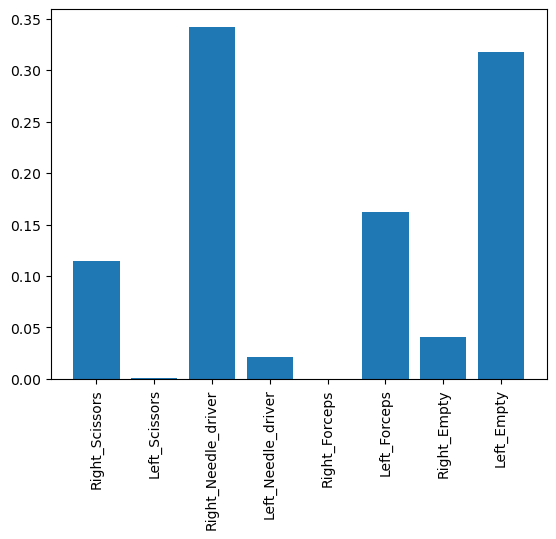

In [16]:
def count_labels(dataset, classes):
    counter = {c: 0 for c in classes}
    for _, labels in dataset:
        for label in labels:
            counter[label[0]] += 1
    return counter

counts = count_labels(ds, classes_encoding.values())
total = sum(counts.values())
plt.bar(range(len(counts)), [v / total for v in counts.values()], align='center')
plt.xticks(range(len(counts)), list(classes_encoding.keys()), rotation=90)
plt.show()